In [13]:
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# 数据预处理

In [3]:
test.head()

,User ID,Age,MonthlySalary,Happiness
0,79470,46,117000,1
1,79363,58,38000,1
2,78782,48,74000,1
3,79207,37,137000,1
4,78375,37,79000,1


In [4]:
testcopy = test.copy()
test_label = testcopy.Happiness

In [5]:
test['Happiness'] = -1

In [6]:
data = pd.concat([train,test],axis=0)

# 特征工程

In [7]:
#年龄分箱
def get_ageSeg(x):
    if x >=0 and x<= 20:
        return 1
    elif x>=21 and x<=30:
        return 2
    elif x>=31 and x<=40:
        return 3
    elif x>=41 and x<=50:
        return 4
    elif x>=51:
        return 5
def get_salarySeg(x):
    if x >=0 and x<= 5000:
        return 1
    elif x>=5001 and x<=10000:
        return 2
    elif x>=10001 and x<=20000:
        return 3
    elif x>=20001:
        return 4
data['ageSeg'] = data.Age.apply(lambda x:get_ageSeg(x))
data['salarySeg'] = data.MonthlySalary.apply(lambda x:get_salarySeg(x))

In [8]:
#年薪
data['YearSalary'] = data.MonthlySalary*12

In [9]:
#ratio比例特征
label_feature =['salarySeg','ageSeg']
data_temp = data[label_feature]
df_feature = pd.DataFrame()
col_type = label_feature.copy()
n = len(col_type)
for i in range(n):
    col_name = "ratio_of_" + col_type[i]
    df_feature[col_name] = (
                    data_temp[col_type[i]].map(data_temp[col_type[i]].value_counts()) / len(data) * 100).astype(int)            
data = pd.concat([data, df_feature], axis=1)

In [10]:
data.head()

,User ID,Age,MonthlySalary,Happiness,ageSeg,salarySeg,YearSalary,ratio_of_salarySeg,ratio_of_ageSeg
0,8.094168e+06,19,19000,0,1,3,228000,5,4
1,8.218457e+06,35,20000,0,3,3,240000,5,35
2,8.123545e+06,26,43000,0,2,4,516000,95,23
3,8.079992e+06,27,57000,0,2,4,684000,95,23
4,8.213829e+06,19,76000,0,1,4,912000,95,4


In [11]:
#count统计特征
cross_feature = []
def get_cross_fe(df):
    first_feature = [ 'ageSeg']
    second_feature = ['salarySeg']
    for feat_1 in first_feature:
        for feat_2 in second_feature:
            col_name = "cross_" + feat_1 + "_and_" + feat_2
            cross_feature.append(col_name)
            df[col_name] = df[feat_1].astype(str).values + '_' + df[feat_2].astype(str).values
    return df
data = get_cross_fe(data)

In [14]:
#labelencoder()
cate_feature = []
cate_features = cate_feature+cross_feature
for item in cate_features:
    data[item] = LabelEncoder().fit_transform(data[item])

In [17]:
def feature_count(data, features=[]):
    new_feature = 'count'
    for i in features:
        new_feature += '_' + i
    try:
        del data[new_feature]
    except:
        pass
    temp = data.groupby(features).size().reset_index().rename(columns={0: new_feature})
    data = data.merge(temp, 'left', on=features)
    return data

for i in cross_feature:
    n = data[i].nunique()
    if n > 5:
        data = feature_count(data, [i])
    else:
        print(i, ':', n)

In [18]:
data.head()

,User ID,Age,MonthlySalary,Happiness,ageSeg,salarySeg,YearSalary,ratio_of_salarySeg,ratio_of_ageSeg,cross_ageSeg_and_salarySeg,count_cross_ageSeg_and_salarySeg
0,8.094168e+06,19,19000,0,1,3,228000,5,4,0,1
1,8.218457e+06,35,20000,0,3,3,240000,5,35,4,5
2,8.123545e+06,26,43000,0,2,4,516000,95,23,3,80
3,8.079992e+06,27,57000,0,2,4,684000,95,23,3,80
4,8.213829e+06,19,76000,0,1,4,912000,95,4,1,18


# 建模预测

In [19]:
train_df = data[data.Happiness!=-1]
test_df = data[data.Happiness==-1]

In [20]:
#删除不需要的列
del_feature = ['User ID','Happiness']
features = [i for i in train_df.columns if i not in del_feature]

In [21]:
train_x = train_df[features]
train_y = train_df['Happiness'].values
test_x = test_df[features]

# 训练参数的选取

In [22]:
params = {'num_leaves': 60,
          'min_data_in_leaf': 30,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.02,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 0.9,
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,
          # 'lambda_l2': 0.001,
          "verbosity": -1,
          "nthread": -1,
          'metric': {'binary_logloss', 'auc'},
          "random_state": 2019,
          }

# 十折交叉

In [23]:
folds = KFold(n_splits=5, shuffle=True, random_state=2048)
prob_oof = np.zeros((train_x.shape[0], ))
test_pred_prob = np.zeros((test_x.shape[0],))

In [24]:
num_round = 1000
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y[trn_idx])
    val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y[val_idx])
    
    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=200,
                    early_stopping_rounds=60)
    prob_oof[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    test_pred_prob += clf.predict(test_x[features], num_iteration=clf.best_iteration) / folds.n_splits

fold 1
Training until validation scores don't improve for 60 rounds.
Early stopping, best iteration is:
[26]	training's auc: 0.96347	training's binary_logloss: 0.398141	valid_1's auc: 0.923006	valid_1's binary_logloss: 0.362707
fold 2
Training until validation scores don't improve for 60 rounds.
Early stopping, best iteration is:
[16]	training's auc: 0.95442	training's binary_logloss: 0.465155	valid_1's auc: 0.952257	valid_1's binary_logloss: 0.421387
fold 3
Training until validation scores don't improve for 60 rounds.
[200]	training's auc: 0.952235	training's binary_logloss: 0.23833	valid_1's auc: 0.955	valid_1's binary_logloss: 0.232149
Early stopping, best iteration is:
[147]	training's auc: 0.951629	training's binary_logloss: 0.24458	valid_1's auc: 0.955	valid_1's binary_logloss: 0.242487
fold 4
Training until validation scores don't improve for 60 rounds.
[200]	training's auc: 0.955517	training's binary_logloss: 0.232141	valid_1's auc: 0.961489	valid_1's binary_logloss: 0.280701
E

# roc评估

In [25]:
sub = test[['User ID']]

In [26]:
#train
roc_auc_score(train_y,prob_oof)

0.9394977168949772

In [27]:
sub['Happiness'] = test_pred_prob

In [28]:
sub['Happiness'] = sub['Happiness'].apply(lambda x:'%.2f'%x)

In [29]:
sub['Happiness']= sub['Happiness'].astype('float')

In [30]:
sub.loc[sub.Happiness<=0.4,'Happiness'] = 0
sub.loc[sub.Happiness>0.4,'Happiness'] = 1

In [31]:
predicton=np.array(sub.Happiness)

In [32]:
predicton

array([1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.])

In [33]:
#test
score = roc_auc_score(predicton,test_label)
score

0.9336065573770491

In [34]:
sub.to_csv('./data/'+str('%.6f'%score)+'.csv',encoding='utf-8',index=False)

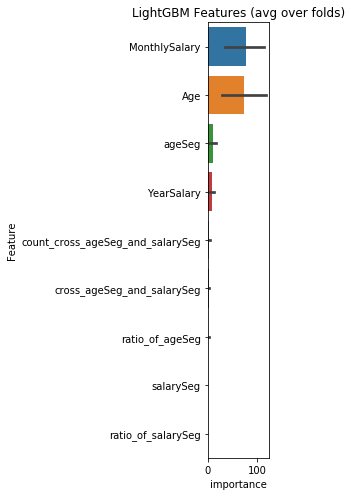

In [35]:
## plot feature importance
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False)[:].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)].sort_values(by='importance',ascending=False)
plt.figure(figsize=(4, 7))
sns.barplot(y="Feature",
            x="importance",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()